In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import gamma as gammadist
from scipy.stats import norm
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
import GPflow as gpf
import tensorflow as tf

%matplotlib notebook

In [67]:
fpath = '/home/mark/Desktop/tmp/2dset'
fnames = [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(38)) ]
def getRMV(fpath,fnames,N):
    R = np.empty([N,len(fnames)])
    T = np.zeros([N,2])
    X = np.array(range(N)).astype(float)
    n = len(fnames)
    for j in range(n):    
        f = os.path.join(fpath,fnames[j])
        #print(f)
        names = (open(f).readline().strip('\n')+''.join([',q{}'.format(i) for i in range(5)])).replace(' ','')
        df = pd.read_csv(f,names=names.split(','),skiprows=1,engine='c')
        tv = np.array(df['taq'].values)
        data =df['trueyatxrecc'].values
        mn = min([i for i in data if i>0])
        data2 = np.maximum(mn,data)
        R[:,j] = np.log10(data2) #swith to abs should be removed. converted to log10
        
        T[:,0] += np.cumsum(tv)
        T[:,1] += np.cumsum(tv)**2
        #print(np.max(np.cumsum(tv)))
        #print(np.max(T))
        #print(T[-1,0],fnames[j])
    #print(R)
    M = np.mean(R,axis=1)
    V = np.var(R,axis=1)
    return X,R,M,V,T,n
#f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,3])
X,R,M,V,Traw,n = getRMV(fpath,fnames,200)
#a[0].plot(X,M,'b')
#a[0].plot(X,R,'.')
#a[0].plot(X,M+2*np.sqrt(V),'b--')
#a[0].plot(X,M-2*np.sqrt(V),'b--')
#a[1].plot(X,Traw[:,0]/n,'b')
#a[1].plot(X,np.sqrt(Traw[:,1]/n-(Traw[:,0]/n)**2),'r')

z = np.linspace(0,220,200)
#print(V)

<IPython.core.display.Javascript object>


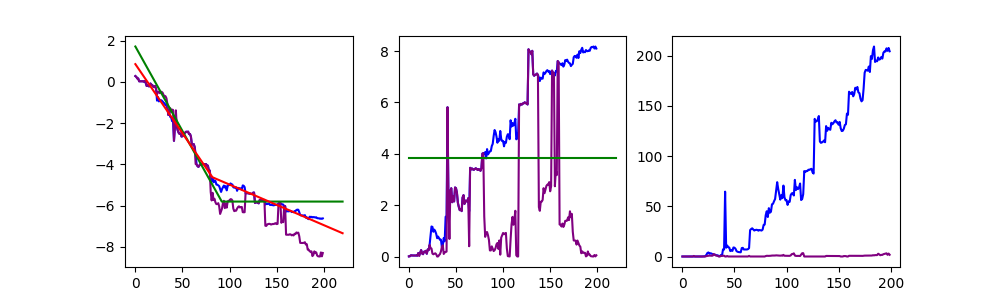

In [141]:
def fitXV(X,M):

    a0=1.
    sigma0=1
    b0=0.1
    c0=1
    def llk(para):
        a = abs(para[0]) # true distribution is a truncated normal in true value?
        b = abs(para[1])
        c = para[2]
        sigma = abs(para[3])
        pa = gammadist.logpdf(a,4.,scale=1.)
        pa+= gammadist.logpdf(b,4.,scale=0.1)
        pa+= norm.logpdf(c,loc=-3.,scale=2)
        pa+= gammadist.logpdf(sigma,1.,scale=1.)
        
        Yh = np.maximum(c*np.ones_like(X),a-b*X)
        E = M-Yh
        return np.sum(((E)**2)/sigma**2)-pa
    res = minimize(llk,[a0,b0,c0,sigma0],method='Nelder-Mead')
    return [abs(res.x[0]),abs(res.x[1]),res.x[2],abs(res.x[3])]

def model(x,theta):
        return np.maximum(theta[0]-theta[1]*x,theta[2]-theta[3]*x)

def fit2line(X,M):
    
    m0 = -min(-1e-9,(M[20]-M[0])/(X[20]-X[0]))
    #m1 = -min(-1e-9,(M[-1]-M[-21])/(X[-1]-X[-21]))
    a0 = M[0]+m0*X[0]
    #a1 = M[-1]+m1*X[-1]
    theta0  = [a0,m0,M[-1],1e-6,1.]
    
    def llk(theta):
        pa = norm.logpdf(theta[0],loc=0.,scale=1.)
        #print(pa,theta[1],gammadist.logpdf(theta[1],4.,scale=1.))
        pa += gammadist.logpdf(theta[1],4.,scale=0.1)
        
        pa += norm.logpdf(theta[2],loc=0.,scale=1.)
        
        pa += gammadist.logpdf(theta[3],4.,scale=0.1)
        pa += gammadist.logpdf(theta[4],2.,scale=0.1)
        Yh = model(X,theta)
        E = M-Yh
        L = np.sum(((E)**2)/theta[4]**2)-pa
        
        return L
    res = minimize(llk,theta0,method='Nelder-Mead')

    return res.x


from scipy import stats
for i in range(1):
    fnames = [f for f in os.listdir(fpath) if f.startswith('eihyp{}_'.format(i)) ]
    #print(fnames)
    X,R,M,V,Traw,n = getRMV(fpath,fnames,200)
    f,a=plt.subplots(nrows=1,ncols=3,figsize=[10,3])
    a[0].plot(X,M,'b')
    a[1].plot(X,V,'b')
    a[2].plot(X,stats.moment(R,4,axis=1),'b')
    
    T = np.vstack([stats.t.fit(R[j,:]) for j in range(R.shape[0])])
    a[0].plot(X,T[:,1],'purple')
    a[1].plot(X,T[:,2]**2,'purple')
    a[2].plot(X,1./T[:,0],'purple')
    aV,bV,cV,sigmaV= fitXV(X[10:],V[10:])
    thetaM = fit2line(X[10:],M[10:])
    
    aM,bM,cM,sigmaV= fitXV(X[10:],M[10:])
    #alphaV,gammaV,sigmaV,betaV = [15,0.6,1e-3,1e-6]
    Vz = np.maximum(cV*np.ones_like(z),aV-bV*z)
    Mz = np.maximum(cM*np.ones_like(z),aM-bM*z)
    M2 = model(z,thetaM)
    a[1].plot(z,Vz,'g')
    a[0].plot(z,Mz,'g')
    a[0].plot(z,M2,'r')

<IPython.core.display.Javascript object>


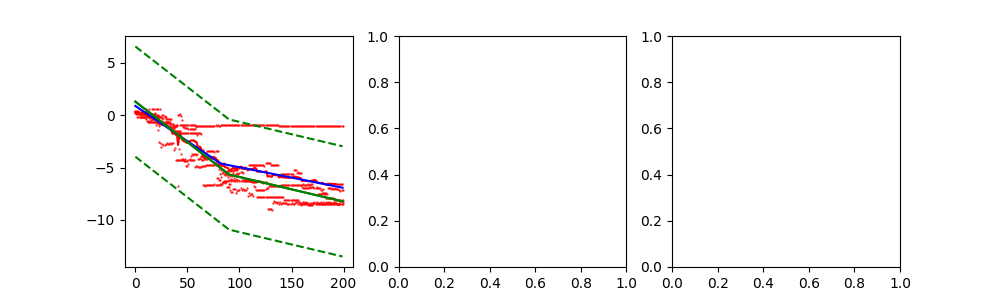

[ 1.28044879  0.07723461 -3.55782563  0.02347601  1.08500136  1.78476272]


<IPython.core.display.Javascript object>


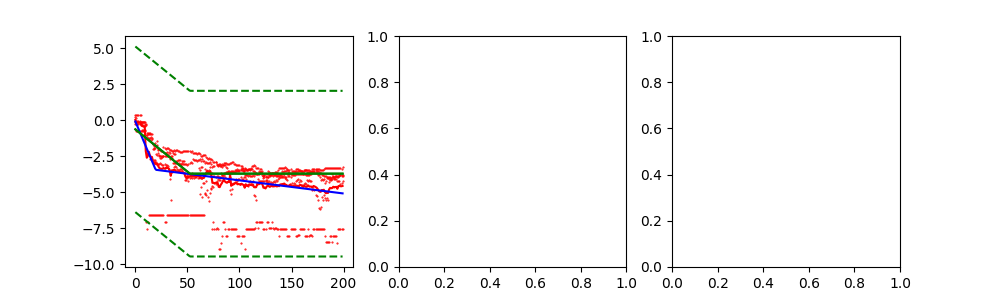

[ -6.21739653e-01   5.88140239e-02  -3.70181953e+00   5.51340359e-06
   4.25085765e-01   9.73798470e-01]


<IPython.core.display.Javascript object>


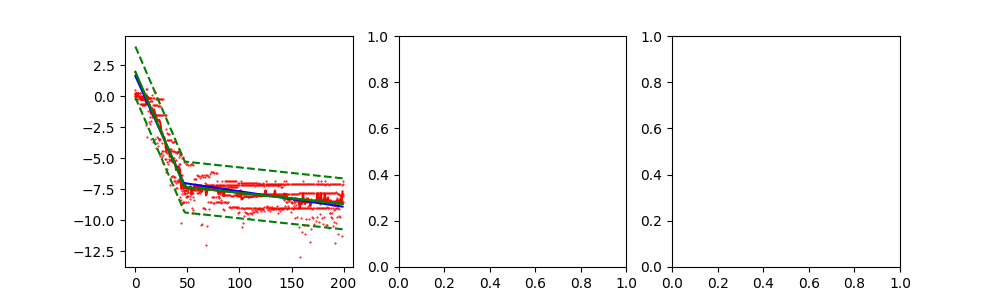

[  1.94885079e+00   1.95626089e-01  -6.90654019e+00   8.90674171e-03
   1.04709584e+00   7.01015989e+04]


<IPython.core.display.Javascript object>


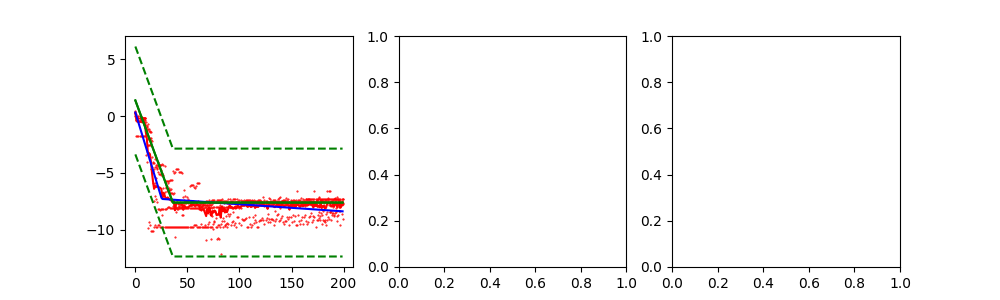

[  1.37585574e+00   2.49592749e-01  -7.60938071e+00   2.66654587e-06
   2.77555905e-01   8.89823621e-01]


<IPython.core.display.Javascript object>


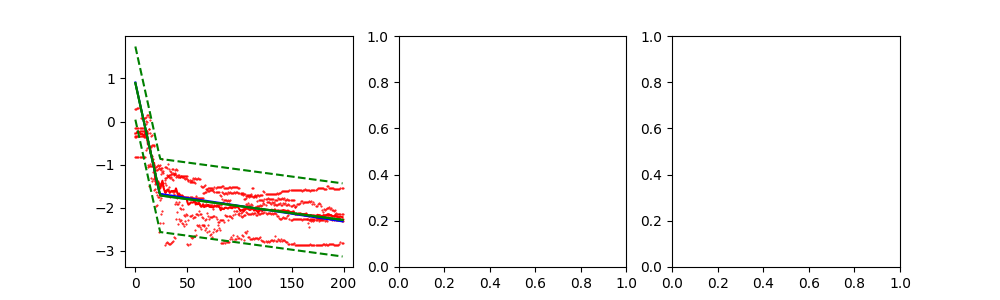

[  8.93730606e-01   1.09539814e-01  -1.63712833e+00   3.23959219e-03
   4.31762979e-01   4.45703833e+02]


<IPython.core.display.Javascript object>


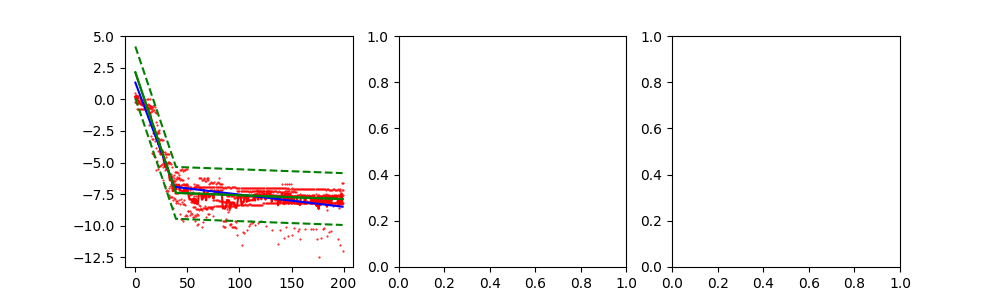

[  2.12167403e+00   2.44661580e-01  -7.28216375e+00   3.04139630e-03
   7.30892736e-01   3.90135575e+00]


<IPython.core.display.Javascript object>


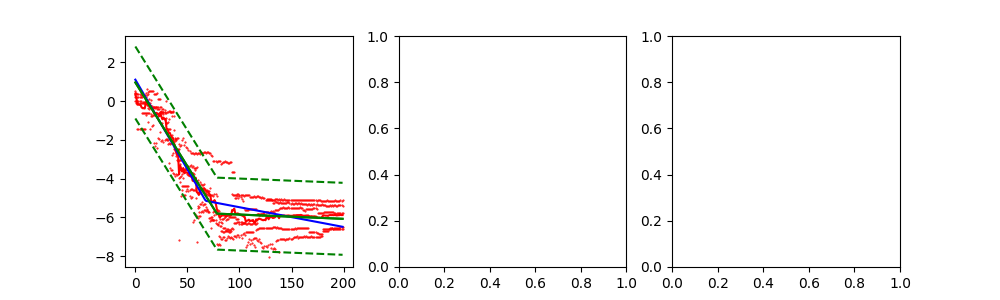

[  9.59670681e-01   8.64398774e-02  -5.63537665e+00   2.20917298e-03
   9.47436977e-01   5.56102459e+03]


<IPython.core.display.Javascript object>


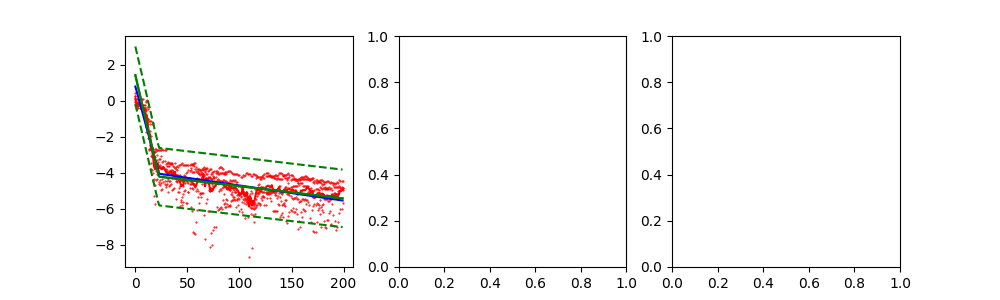

[  1.42839964e+00   2.48811836e-01  -4.06177010e+00   6.85389131e-03
   8.12560603e-01   2.35823930e+02]


<IPython.core.display.Javascript object>


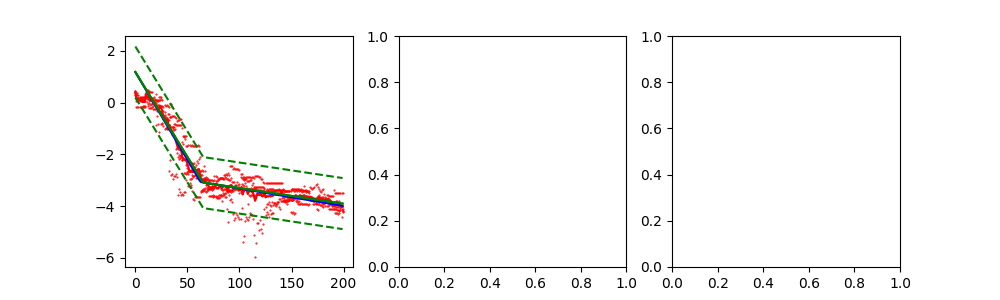

[ 1.18576395  0.06564246 -2.6960309   0.00606629  0.31810259  3.13941951]


<IPython.core.display.Javascript object>


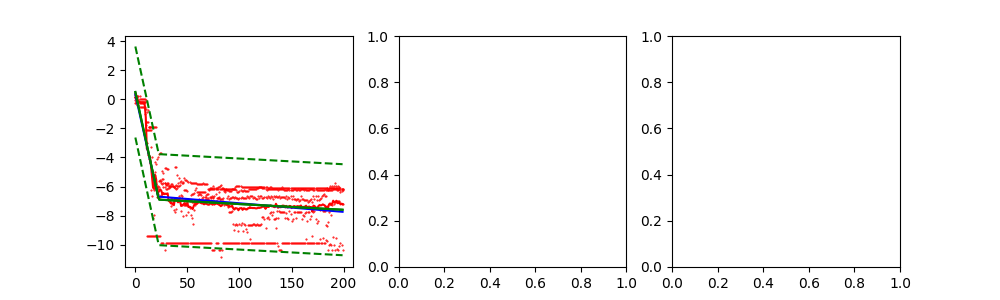

[  5.01434641e-01   3.29326165e-01  -6.81279226e+00   3.92952824e-03
   1.59699634e+00   1.11617546e+04]


In [187]:

def fittshape(X,M,R):
    u = R.shape[1]
    m0 = -min(-1e-9,(M[20]-M[0])/(X[20]-X[0]))
    a0 = M[0]+m0*X[0]
    theta0  = [a0,m0,M[-1],1e-6,2.,3.]
    def llk(theta):
        pa = norm.logpdf(theta[0],loc=0.,scale=1.)
        pa += gammadist.logpdf(theta[1],4.,scale=0.1)
        pa += norm.logpdf(theta[2],loc=0.,scale=1.)
        pa += gammadist.logpdf(theta[3],4.,scale=0.1)
        pa += gammadist.logpdf(theta[4],4.,scale=2.)
        pa += gammadist.logpdf(1./theta[5],1.,scale=1.)
        Yh = model(X,theta)
        L = -pa
        for i in range(u):
            E = R[:,i]-Yh
            L-=np.sum(stats.t.logpdf(E,loc=0.,scale=theta[4],df=theta[5]))
        return L
    res = minimize(llk,theta0,method='Nelder-Mead')

    return res.x
 
for i in range(10):
    fnames = [f for f in os.listdir(fpath) if f.startswith('eihyp{}_'.format(i)) ]
    #print(fnames)
    X,R,M,V,Traw,n = getRMV(fpath,fnames,200)
    f,a=plt.subplots(nrows=1,ncols=3,figsize=[10,3])
    
    theta = fittshape(X[10:],M[10:],R[10:,:])
    theta2 = fit2line(X[10:],M[10:])
    a[0].plot(X,R,'r.',ms=1)
    a[0].plot(X,M,'r')
    #a[0].plot(X,M-2*np.sqrt(V),'r--')
    #a[0].plot(X,M+2*np.sqrt(V),'r--')
    
    a[0].plot(X,model(X,theta2),'b')
    a[0].plot(X,model(X,theta),'g')
    iv = stats.t.interval(0.95,df = theta[5],scale=theta[4],loc=0.)
    a[0].plot(X,model(X,theta)+iv[0],'g--')
    a[0].plot(X,model(X,theta)-iv[0],'g--')
    a[0].plot(X,model(X,theta),'g')
    print(theta)

<IPython.core.display.Javascript object>


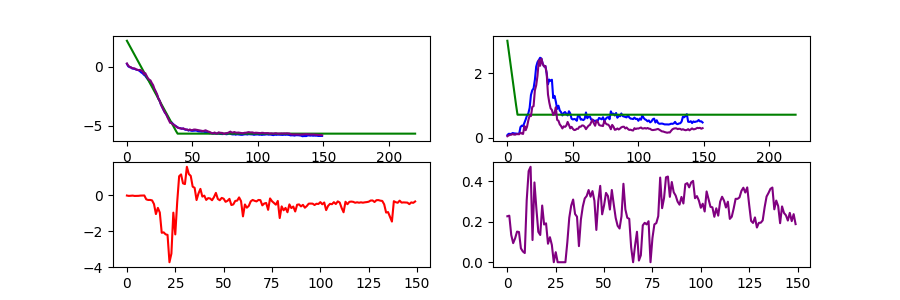

In [189]:
from scipy import stats

fnames = [f for f in os.listdir('/home/mark/Desktop/tmp/fix') if f.startswith('eihyp{}_'.format(0)) ]
#print(fnames)
X,R,M,V,Traw,n = getRMV('/home/mark/Desktop/tmp/fix',fnames,150)
f,a=plt.subplots(nrows=2,ncols=2,figsize=[9,3])
a[0,0].plot(X,M,'b')
a[0,1].plot(X,V,'b')
aV,bV,cV,sigmaV= fitXV(X[10:],V[10:])
aM,bM,cM,sigmaV= fitXV(X[10:],M[10:])
#alphaV,gammaV,sigmaV,betaV = [15,0.6,1e-3,1e-6]
Vz = np.maximum(cV*np.ones_like(z),aV-bV*z)
Mz = np.maximum(cM*np.ones_like(z),aM-bM*z)
a[0,1].plot(z,Vz,'g')
a[0,0].plot(z,Mz,'g')
a[1,0].plot(X,stats.moment(R,3,axis=1),'r')
#a[1,1].plot(X,stats.moment(R,4,axis=1),'r')
T = np.vstack([stats.t.fit(R[j,:]) for j in range(R.shape[0])])
a[0,0].plot(X,T[:,1],'purple')
a[0,1].plot(X,T[:,2]**2,'purple')
a[1,1].plot(X,1./T[:,0],'purple')

<IPython.core.display.Javascript object>


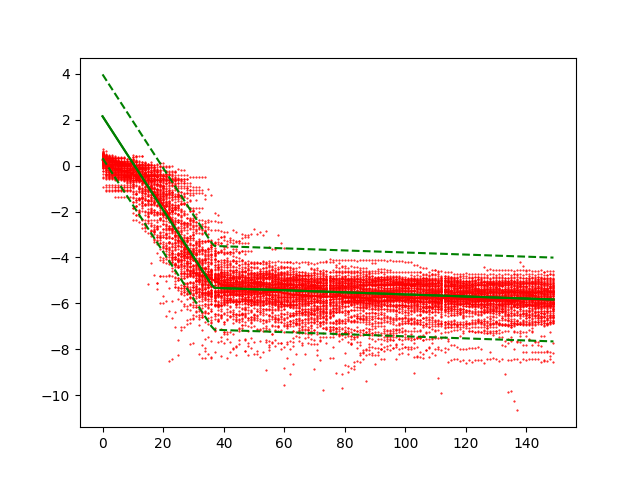

[  2.14204647e+00   2.03304631e-01  -5.15389234e+00   4.52251739e-03
   6.01109464e-01   3.28251207e+00]


In [191]:
f,a = plt.subplots()
theta = fittshape(X[10:],M[10:],R[10:,:])
theta2 = fit2line(X[10:],M[10:])
a.plot(X,R,'r.',ms=1)
a.plot(X,M,'r')
#[0].plot(X,M-2*np.sqrt(V),'r--')
#a[0].plot(X,M+2*np.sqrt(V),'r--')
  
#a.plot(X,model(X,theta2),'b')
a.plot(X,model(X,theta),'g')
iv = stats.t.interval(0.95,df = theta[5],scale=theta[4],loc=0.)
a.plot(X,model(X,theta)+iv[0],'g--')
a.plot(X,model(X,theta)-iv[0],'g--')
a.plot(X,model(X,theta),'g')
print(theta)

<IPython.core.display.Javascript object>


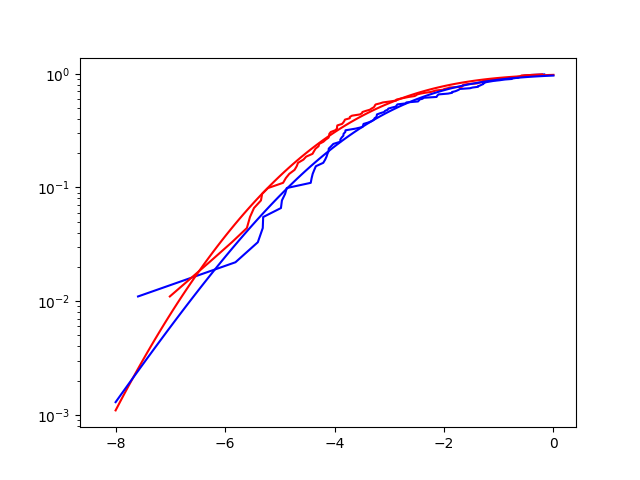

In [136]:
plt.figure()
plt.plot(np.sort(R[25,:]),np.array(range(R.shape[1]))/R.shape[1],'b')
plt.plot(np.sort(R[26,:]),np.array(range(R.shape[1]))/R.shape[1],'r')
plt.plot(np.linspace(-8,0,100),stats.t(*stats.t.fit(R[26,:])).cdf(np.linspace(-8,0,100)),'r')
plt.semilogy(np.linspace(-8,0,100),stats.t(*stats.t.fit(R[25,:])).cdf(np.linspace(-8,0,100)),'b')

In [154]:
stats.t.logpdf(np.linspace(-1,1,10),df=3,loc=0.,scale=1.)

array([-1.4244838 , -1.22652292, -1.07748498, -0.97785445, -0.92795725,
       -0.92795725, -0.97785445, -1.07748498, -1.22652292, -1.4244838 ])

In [185]:
norm.interval(0.95,scale=1.)

(-1.959963984540054, 1.959963984540054)

In [194]:
import pickle
g = pickle.load(open('/home/mark/Desktop/data.p','rb'))

ModuleNotFoundError: No module named 'gpbo'